In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import model_selection, metrics
import matplotlib.pyplot as plt
import seaborn as sns
import math

import os
print(os.listdir("."))

['model1 - NaiveModels.ipynb', '.ipynb_checkpoints', 'model3 - OutlinersModels.ipynb', 'model2.csv', 'test.csv', 'train.csv', 'model2 - NaNHandleModels.ipynb', 'model3.csv', 'model1.csv', 'EDA.ipynb']


In [2]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

In [3]:
def load_data(train_path='train.csv', test_path='test.csv'):
    train = pd.DataFrame.from_csv(train_path, index_col=0)
    test = pd.DataFrame.from_csv(test_path, index_col=0)
              
    return train, test

In [4]:
train, test = load_data()

/home/lazukav/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
/home/lazukav/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
def normalize(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return dataNorm

def proc_data(data):
#     num = normalize(data.select_dtypes(exclude=["object"]))
    num = data.select_dtypes(exclude=["object"])
    cat = data.select_dtypes(include=["object"])

    return pd.concat([num, cat], axis=1, sort=False)

In [6]:
train = proc_data(train[['YearBuilt', "SaleCondition", "SalePrice"]])
test = proc_data(test[['YearBuilt', "SaleCondition"]])

In [7]:
train.dropna(inplace=True, axis=0)
test.dropna(inplace=True, axis=0)

In [8]:
train.head()

,YearBuilt,SalePrice,SaleCondition
Id,,,
1,2003,208500,Normal
2,1976,181500,Normal
3,2001,223500,Normal
4,1915,140000,Abnorml
5,2000,250000,Normal


In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train.drop("SalePrice", axis=1), train.SalePrice, test_size=0.2, shuffle=None)

In [10]:
def regressor_model(
    learning_rate,
    steps,
    batch_size,
    X_train,
    y_train,
    X_test,
    y_test,
    cols,
    m_dir,
    periods):
    
    steps_per_period = steps / periods

    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
    regressor = tf.estimator.LinearRegressor(
        feature_columns=cols,
        optimizer=my_optimizer,
        model_dir=m_dir
    )
  
    training_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        shuffle=True,
    )

    ptraining_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        num_epochs=1,
        shuffle=False,
    )

    validation_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        y=y_test,
        num_epochs=1,
        shuffle=False 
    )
  
    print("Training model...")
    print("LogLoss (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        
        regressor.evaluate(input_fn=validation_input_fn)
        
        training_predictions = regressor.predict(input_fn=ptraining_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions = regressor.predict(input_fn=validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, y_train))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, y_test))

        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))

        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

    return regressor, training_rmse, validation_rmse

In [11]:
# cond = tf.feature_column.categorical_column_with_vocabulary_list('SaleCondition', ['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'])
cols = [tf.feature_column.numeric_column(i) for i in train.drop('SalePrice', axis=1).select_dtypes(exclude=['object']).columns.values]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_evaluation_master': '', '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_train_distribute': None, '_save_summary_steps': 100, '_device_fn': None, '_eval_distribute': None, '_save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8748c47f28>, '_experimental_distribute': None, '_task_type': 'worker', '_model_dir': '/tmp/model1', '_protocol': None, '_is_chief': True, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_tf_random_seed': None, '_keep_checkpoint_max': 5, '_session_config': allow_soft_placement: true
graph_o

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-30
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
  period 02 : 195339.30
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-30
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 30 into /tmp/model1/model.ckpt.
INFO:tensorflow:loss = 4409667000000.0, step = 31
INFO:tensorflow:Saving checkpoints for 40 into /tmp/model1/model.ckpt.
INFO:tensorflow:Loss for final step: 718451400000.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tens

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-24T09:07:45Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-80
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-24-09:07:46
INFO:tensorflow:Saving dict for global step 80: average_loss = 39016247000.0, global_step = 80, label/mean = 179909.4, loss = 3797581600000.0, prediction/mean = 3944.8896
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 80: /tmp/model1/model.ckpt-80
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-80
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Grap

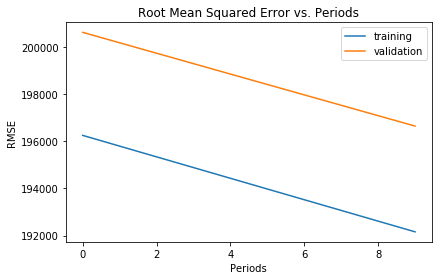

In [12]:
model1 = regressor_model(
    learning_rate=0.005,
    steps=500,
    batch_size=10,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cols=cols,
    m_dir='/tmp/model1',
    periods=10)

In [13]:
scores1 = model1[0].predict(input_fn=tf.estimator.inputs.pandas_input_fn(x=test,
                                                                      num_epochs=1,
                                                                      shuffle=False))

res = []
for i, p in enumerate(scores1):
    res.append([i + 1461, p['predictions'][0]])

result = pd.DataFrame(res, columns=['Id', 'SalePrice'])
result.to_csv('model1.csv', index=None)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
